In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#VISIOPE Final Project Academic Year 21/22
##Mert YILDIZ, 1951070 
##Yunus Emre DARICI, 1900161
##Vishnu Chirukandath RAMESH, 1921535

#Import packages

In [2]:
from keras.datasets import cifar100
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ReLU, MaxPool2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import trange
from keras.engine import training

#Download the data and convert the labels

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="coarse")

169017344/169001437 [==============================] - 13s 0us/step


In [4]:
# Change the labels from categorical to one-hot encoding
y_onehot_train = to_categorical(y_train)
y_onehot_test = to_categorical(y_test)

#Compute red, green and blue pixel probability distributions

In [5]:
def compute_probabilities(bin_size,x):
  #Initialize arrays to store pixels probability distributions
  red_pixels=np.ones(256//bin_size+1)
  green_pixels=np.ones(256//bin_size+1)
  blue_pixels=np.ones(256//bin_size+1)

  #Build the probability distributions
  for img in tqdm(x):
    for pixel in img[:,:,0].flatten():
      red_pixels[pixel//bin_size]+=1
    for pixel in img[:,:,1].flatten():
      green_pixels[pixel//bin_size]+=1
    for pixel in img[:,:,2].flatten():
      blue_pixels[pixel//bin_size]+=1  

  #The total number of pixel seen is 
  n_pixels=x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3]

  #Normalize probabilities
  red_pixels_prob=red_pixels/n_pixels
  green_pixels_prob=green_pixels/n_pixels
  blue_pixels_prob=blue_pixels/n_pixels

  return(red_pixels_prob,green_pixels_prob,blue_pixels_prob)

In [6]:
#Define bin size over which pixel values will be discretized
bin_size=1
red_pixels_prob,green_pixels_prob,blue_pixels_prob=compute_probabilities(bin_size,x_train)

100%|██████████| 50000/50000 [07:07<00:00, 117.06it/s]


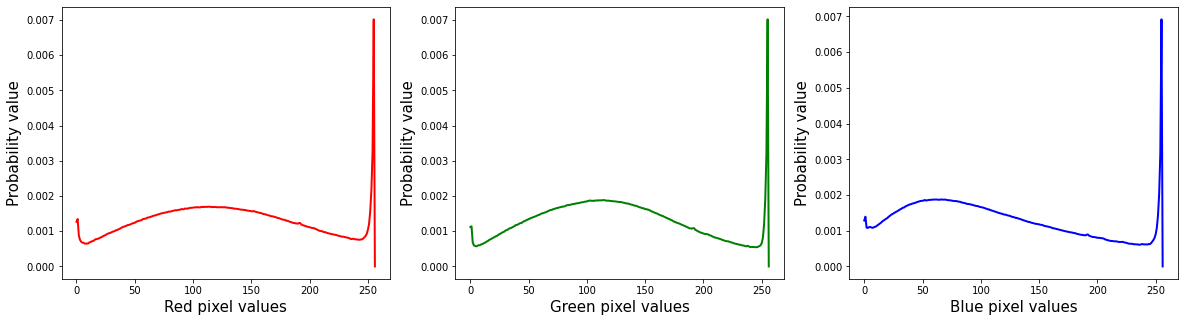

In [7]:
# Plot pixel probability distributions
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,5))
ax1.plot(red_pixels_prob,color="red",linewidth=2)
ax1.set_xlabel("Red pixel values",fontsize=15)
ax1.set_ylabel("Probability value",fontsize=15)
ax2.plot(green_pixels_prob,color="green",linewidth=2)
ax2.set_xlabel("Green pixel values",fontsize=15)
ax2.set_ylabel("Probability value",fontsize=15)
ax3.plot(blue_pixels_prob,color="blue",linewidth=2)
ax3.set_xlabel("Blue pixel values",fontsize=15)
ax3.set_ylabel("Probability value",fontsize=15)
plt.show()

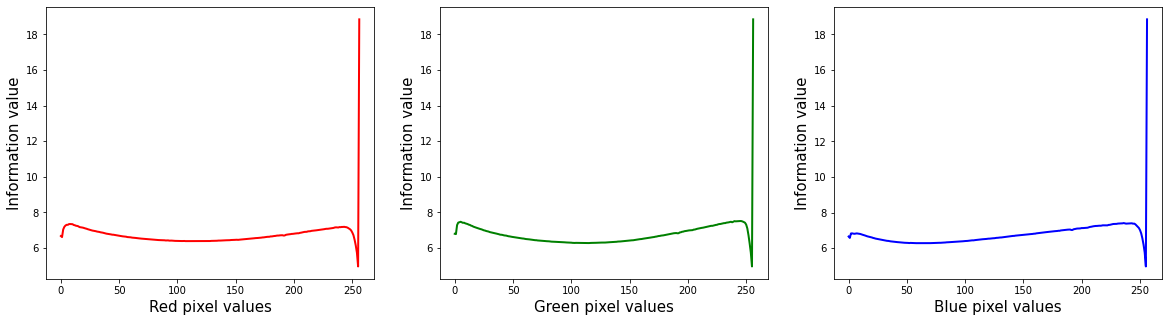

In [8]:
#Plot information values 
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,5))
ax1.plot(-np.log(red_pixels_prob),color="red",linewidth=2)
ax1.set_xlabel("Red pixel values",fontsize=15)
ax1.set_ylabel("Information value",fontsize=15)
ax2.plot(-np.log(green_pixels_prob),color="green",linewidth=2)
ax2.set_xlabel("Green pixel values",fontsize=15)
ax2.set_ylabel("Information value",fontsize=15)
ax3.plot(-np.log(blue_pixels_prob),color="blue",linewidth=2)
ax3.set_xlabel("Blue pixel values",fontsize=15)
ax3.set_ylabel("Information value",fontsize=15)
plt.show()

#1° approach: Augment images with Shannon information layers 

In [9]:
def augment_dataset(informations,x,binsize):
  
  #Define modified_dataset np array to store augmented data
  modified_dataset=np.zeros((x.shape[0],x.shape[1],x.shape[2],2*x.shape[3]))
  
  #Append information layers to dataset
  for i, img in enumerate(tqdm(x)):
    
    #Define an empty information tensor
    inf_layers=np.zeros((x.shape[1],x.shape[2],x.shape[3]))

    for color in range(x.shape[3]):
      for row in range(x.shape[1]):
        for column in range(x.shape[2]):
          pixel_value=img[row,column,color]
          inf_layers[row,column,color]=informations[pixel_value//binsize,color]

    img=np.concatenate((img/255,inf_layers),axis=-1)
    modified_dataset[i]=img

  return(modified_dataset)

In [10]:
#Reshape probabilities arrays in order to build a general tensor
red_pixels_prob=red_pixels_prob.reshape(len(red_pixels_prob), 1)
green_pixels_prob=green_pixels_prob.reshape(len(green_pixels_prob), 1)
blue_pixels_prob=blue_pixels_prob.reshape(len(blue_pixels_prob), 1)

#Concatenate all probabilities into a single tensor 
probs=np.concatenate((red_pixels_prob,green_pixels_prob,blue_pixels_prob),axis=1)

#Compute informations and normalize them in the interval 0-1
infos=-np.log(probs)
infos=infos/np.max(infos)

#Concatenate train and test images: both has to be augmented with 
#the probabilities computed only over the training set

x=np.concatenate((x_train, x_test), axis=0)

modified_dataset=augment_dataset(infos,x,bin_size)

100%|██████████| 60000/60000 [08:34<00:00, 116.65it/s]


In [5]:
# # Store/Load modified dataset
#np.save("/content/drive/MyDrive/Data/VISIOPE/modified_dataset.npy", modified_dataset)
modified_dataset = np.load("/content/drive/MyDrive/Data/VISIOPE/modified_dataset.npy")


#Split back the dataset into training and test subsets
x_train_augmented=modified_dataset[:x_train.shape[0]]
x_test_augmented=modified_dataset[x_train.shape[0]:]

#2° approach: modding of the onehot labels to let them contain Shannon informations

In [6]:
#Define empy object to contain all the labels in the train set
modded_y=np.zeros((y_onehot_train.shape[0],21))

#Append to those label the sum of informations
for i in range(y_onehot_train.shape[0]):
  modded_y[i]=np.append(y_onehot_train[i],np.mean(x_train_augmented[i][:,:,3:]))

In [7]:
#Since the true labels now contains one extra eelemnt, we need to rewrite our custom 
#loss and custom function to be used by the model to compute the accuracy

def own_loss(Lambda=0.1): 

  def custom_loss(y_mod, y_pred):
    #Extract true one hot labels 
    y_true=y_mod[:,:20]

    #Compute normalcategorical crossentropy
    normal_loss=tf.keras.losses.CategoricalCrossentropy()
    therm1=normal_loss(y_true,y_pred)
    
    #Compute regularization therm
    y_pred=tf.math.round(y_pred)
    diff=tf.math.square(y_true-y_pred)
    differences = tf.reduce_sum(diff, axis=1)/2
    reg_therms=y_mod[:,-1]
    therm2=tf.reduce_sum(differences*reg_therms)/(tf.keras.backend.int_shape(y_true)[0])*Lambda

    #Return both therms
    return therm1+therm2

  return custom_loss


def accuracy(y_mod,y_pred):
  y_true=y_mod[:,:20]

  return tf.keras.backend.mean(tf.keras.backend.equal(tf.keras.backend.argmax(y_true, axis=-1),tf.keras.backend.argmax(y_pred, axis=-1)))

#Define functions to create model and fit it

In [8]:
from keras.backend import shape
def create_fit_model(batch_size,epochs,num_classes,train_data,train_label,l2,dropout_plevel,loss_function,metric_function,train_verbosity,stopping_patience):

  X_train,valid_X,train_label,valid_label = train_test_split(train_data, train_label, test_size=0.2, random_state=13)
  
  #Define shape of input
  shape_of_input=train_data[0].shape
  
  #Define model
  conv_net = Sequential()

  #1 convolutional block
  conv_net.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=shape_of_input,activation="linear",padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #2 convolutional block
  conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #3 convolutional block
  conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #4 convolutional block
  conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #5 convolutional block
  conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #Dense classifier
  conv_net.add(Flatten())
  conv_net.add(Dense(512, activation='linear',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(ReLU())
  conv_net.add(Dense(20, activation='softmax'))


  #Compile and train model
  earlyStopping = EarlyStopping(monitor='val_loss', patience=stopping_patience, verbose=0, mode='min')
  mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
  conv_net.compile(loss=loss_function, optimizer=keras.optimizers.Adam(),metrics=[metric_function])
  conv_train = conv_net.fit(X_train, train_label,batch_size=batch_size,epochs=epochs,verbose=train_verbosity,validation_data=(valid_X, valid_label), callbacks=[earlyStopping, mcp_save])

  return(conv_net,conv_train)

In [9]:
class MCDropout(keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)


def get_predictions_with_uncertainty(model, X):
    
    predictions = []
    for i in range(10): # can be made more efficient by just forward passing several times through the last layer
        predictions.append(model.predict(X))
    predictions = np.array(predictions)
    
    means = np.mean(predictions, axis=0)
    std = np.std(predictions, axis=0)
    preds = np.argmax(means, axis=1)
    preds_std = np.array([std[i, preds[i]] for i in range(len(preds))])

    return preds, preds_std

#Define functions to print test results and plots

In [10]:
def predicts_with_model(conv_net,x_test,y_test,dropout_plevel):
  onehot_test_predictions = conv_net.predict(x_test,verbose=0)
  test_predictions=np.array([np.argmax(el) for el in onehot_test_predictions])
  print("Accuracy over the test with normal dropout (P value: ",dropout_plevel,") set is: ",sum(test_predictions==y_test[:,0])/len(y_test))


  preds, stds = get_predictions_with_uncertainty(model=conv_net, X=x_test)
  labels = y_test[:,0] #np.argmax(y_test, axis=1)

  print('Accuracy over test set with MC dropout (P value: ',dropout_plevel,') set is: ' + str((preds == labels).sum()/len(labels)))

  misclassified_mask = labels != preds

  print('Average standard deviation of classification: ' + str(np.mean(stds)))
  print('Average standard deviation of misclassified samples: ' + str(np.mean(stds[misclassified_mask])))

def plot_loss(conv_train):
  accuracy = conv_train.history['accuracy']
  val_accuracy = conv_train.history['val_accuracy']
  loss = conv_train.history['loss']
  val_loss = conv_train.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

#Without Dropout...

##Implement model over normal images without dropout without regularization

In [12]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=y_onehot_train,l2=0,dropout_plevel=0,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=5)

Epoch 1/50
200/200 [==============================] - 31s 69ms/step - loss: 2.6186 - accuracy: 0.1728 - val_loss: 2.3584 - val_accuracy: 0.2640
Epoch 2/50
200/200 [==============================] - 14s 67ms/step - loss: 2.1930 - accuracy: 0.3128 - val_loss: 2.0322 - val_accuracy: 0.3631
Epoch 3/50
200/200 [==============================] - 13s 67ms/step - loss: 1.9185 - accuracy: 0.3992 - val_loss: 1.8681 - val_accuracy: 0.4204
Epoch 4/50
200/200 [==============================] - 13s 67ms/step - loss: 1.6989 - accuracy: 0.4654 - val_loss: 1.7284 - val_accuracy: 0.4591
Epoch 5/50
200/200 [==============================] - 14s 68ms/step - loss: 1.4994 - accuracy: 0.5245 - val_loss: 1.6576 - val_accuracy: 0.4833
Epoch 6/50
200/200 [==============================] - 13s 68ms/step - loss: 1.3037 - accuracy: 0.5833 - val_loss: 1.5600 - val_accuracy: 0.5173
Epoch 7/50
200/200 [==============================] - 14s 69ms/step - loss: 1.1097 - accuracy: 0.6413 - val_loss: 1.5328 - val_accuracy:

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0)

Accuracy over the test with normal dropout (P value:  0 ) set is:  0.5503
Accuracy over test set with MC dropout (P value:  0 ) set is: 0.5503
Average standard deviation of classification: 3.8173795e-08
Average standard deviation of misclassified samples: 3.5796585e-08


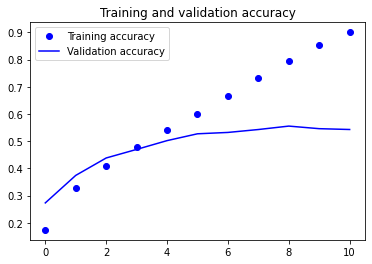

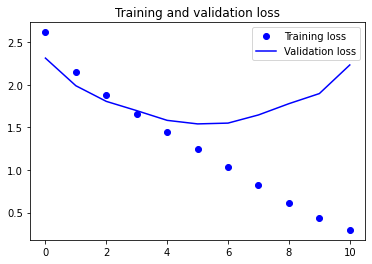

In [ ]:
plot_loss(conv_train)

##Implement model over augmented images without dropout without regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train_augmented,
                                     train_label=y_onehot_train,l2=0,dropout_plevel=0,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=5)

Epoch 1/50
200/200 [==============================] - 17s 76ms/step - loss: 2.6106 - accuracy: 0.1780 - val_loss: 2.3817 - val_accuracy: 0.2540
Epoch 2/50
200/200 [==============================] - 15s 73ms/step - loss: 2.2126 - accuracy: 0.3080 - val_loss: 2.1168 - val_accuracy: 0.3370
Epoch 3/50
200/200 [==============================] - 15s 73ms/step - loss: 1.9721 - accuracy: 0.3851 - val_loss: 1.9658 - val_accuracy: 0.3866
Epoch 4/50
200/200 [==============================] - 14s 72ms/step - loss: 1.7837 - accuracy: 0.4401 - val_loss: 1.7990 - val_accuracy: 0.4369
Epoch 5/50
200/200 [==============================] - 14s 72ms/step - loss: 1.6039 - accuracy: 0.4958 - val_loss: 1.7180 - val_accuracy: 0.4584
Epoch 6/50
200/200 [==============================] - 14s 71ms/step - loss: 1.4238 - accuracy: 0.5462 - val_loss: 1.6752 - val_accuracy: 0.4748
Epoch 7/50
200/200 [==============================] - 14s 72ms/step - loss: 1.2349 - accuracy: 0.6046 - val_loss: 1.6717 - val_accuracy:

In [ ]:
predicts_with_model(conv_net,x_test_augmented,y_test,dropout_plevel=0)

Accuracy over the test with normal dropout (P value:  0 ) set is:  0.5041
Accuracy over test set with MC dropout (P value:  0 ) set is: 0.5041
Average standard deviation of classification: 3.8141014e-08
Average standard deviation of misclassified samples: 3.7068105e-08


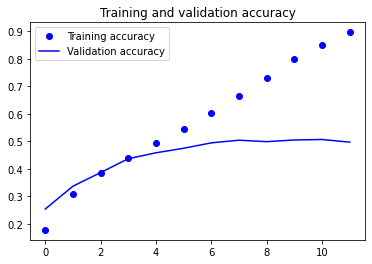

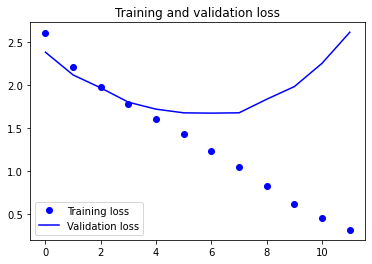

In [ ]:
plot_loss(conv_train)

##Implement model over original images without dropout with own regularization 

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=modded_y,l2=0,dropout_plevel=0,
                                     loss_function=own_loss(Lambda=0.01),metric_function=accuracy,
                                     train_verbosity=1,stopping_patience=5)

Epoch 1/50
200/200 [==============================] - 16s 72ms/step - loss: 2.5903 - accuracy: 0.1840 - val_loss: 2.3220 - val_accuracy: 0.2725
Epoch 2/50
200/200 [==============================] - 14s 70ms/step - loss: 2.1354 - accuracy: 0.3336 - val_loss: 2.0499 - val_accuracy: 0.3580
Epoch 3/50
200/200 [==============================] - 14s 69ms/step - loss: 1.8548 - accuracy: 0.4177 - val_loss: 1.8212 - val_accuracy: 0.4262
Epoch 4/50
200/200 [==============================] - 14s 68ms/step - loss: 1.6160 - accuracy: 0.4907 - val_loss: 1.6370 - val_accuracy: 0.4859
Epoch 5/50
200/200 [==============================] - 14s 69ms/step - loss: 1.4110 - accuracy: 0.5532 - val_loss: 1.5765 - val_accuracy: 0.5118
Epoch 6/50
200/200 [==============================] - 14s 68ms/step - loss: 1.1805 - accuracy: 0.6208 - val_loss: 1.5407 - val_accuracy: 0.5292
Epoch 7/50
200/200 [==============================] - 14s 68ms/step - loss: 0.9451 - accuracy: 0.6927 - val_loss: 1.5778 - val_accuracy:

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0)

Accuracy over the test with normal dropout (P value:  0 ) set is:  0.5443
Accuracy over test set with MC dropout (P value:  0 ) set is: 0.5443
Average standard deviation of classification: 3.9027633e-08
Average standard deviation of misclassified samples: 3.6803286e-08


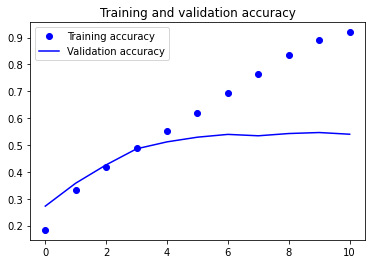

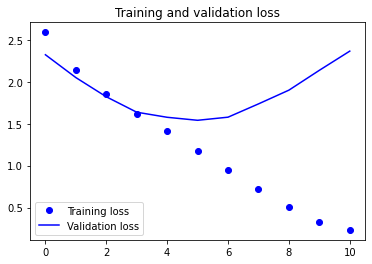

In [ ]:
plot_loss(conv_train)

##Implement model over original images without dropout with L2 regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=y_onehot_train,l2=0.0005,dropout_plevel=0,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=5)

Epoch 1/50
200/200 [==============================] - 16s 71ms/step - loss: 2.8503 - accuracy: 0.1436 - val_loss: 2.6252 - val_accuracy: 0.2042
Epoch 2/50
200/200 [==============================] - 14s 70ms/step - loss: 2.4890 - accuracy: 0.2437 - val_loss: 2.3760 - val_accuracy: 0.2880
Epoch 3/50
200/200 [==============================] - 14s 70ms/step - loss: 2.3085 - accuracy: 0.3157 - val_loss: 2.2631 - val_accuracy: 0.3404
Epoch 4/50
200/200 [==============================] - 14s 69ms/step - loss: 2.1662 - accuracy: 0.3635 - val_loss: 2.1426 - val_accuracy: 0.3744
Epoch 5/50
200/200 [==============================] - 14s 69ms/step - loss: 2.0571 - accuracy: 0.4042 - val_loss: 2.0205 - val_accuracy: 0.4159
Epoch 6/50
200/200 [==============================] - 14s 69ms/step - loss: 1.9618 - accuracy: 0.4397 - val_loss: 1.9539 - val_accuracy: 0.4480
Epoch 7/50
200/200 [==============================] - 14s 69ms/step - loss: 1.8673 - accuracy: 0.4749 - val_loss: 1.9160 - val_accuracy:

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0)

Accuracy over the test with normal dropout (P value:  0 ) set is:  0.567
Accuracy over test set with MC dropout (P value:  0 ) set is: 0.567
Average standard deviation of classification: 3.3548474e-08
Average standard deviation of misclassified samples: 2.7637697e-08


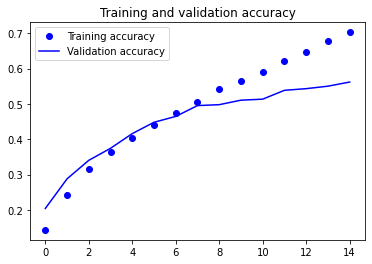

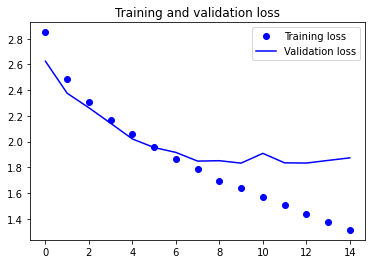

In [ ]:
plot_loss(conv_train)

#...with Dropout

##Implement model over normal images with dropout without regularization

In [13]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=y_onehot_train,l2=0,dropout_plevel=0.4,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=20)

Epoch 1/50
200/200 [==============================] - 19s 92ms/step - loss: 2.7113 - accuracy: 0.1458 - val_loss: 2.5009 - val_accuracy: 0.2194
Epoch 2/50
200/200 [==============================] - 19s 95ms/step - loss: 2.3391 - accuracy: 0.2706 - val_loss: 2.2602 - val_accuracy: 0.2980
Epoch 3/50
200/200 [==============================] - 18s 89ms/step - loss: 2.1075 - accuracy: 0.3427 - val_loss: 2.0337 - val_accuracy: 0.3675
Epoch 4/50
200/200 [==============================] - 19s 95ms/step - loss: 1.9448 - accuracy: 0.3959 - val_loss: 1.9485 - val_accuracy: 0.4016
Epoch 5/50
200/200 [==============================] - 18s 88ms/step - loss: 1.8073 - accuracy: 0.4345 - val_loss: 1.8257 - val_accuracy: 0.4255
Epoch 6/50
200/200 [==============================] - 18s 89ms/step - loss: 1.7012 - accuracy: 0.4659 - val_loss: 1.7806 - val_accuracy: 0.4469
Epoch 7/50
200/200 [==============================] - 19s 94ms/step - loss: 1.6051 - accuracy: 0.4949 - val_loss: 1.7231 - val_accuracy:

In [14]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0.4)

Accuracy over the test with normal dropout (P value:  0.4 ) set is:  0.5423
Accuracy over test set with MC dropout (P value:  0.4 ) set is: 0.6124
Average standard deviation of classification: 0.21070947
Average standard deviation of misclassified samples: 0.25241217


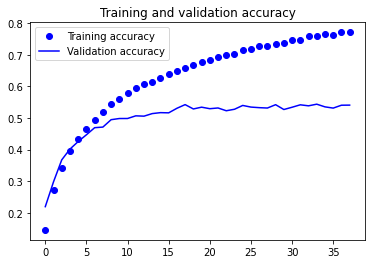

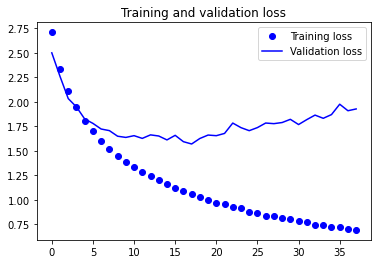

In [15]:
plot_loss(conv_train)

##Implement model over augmented images with dropout without regularization

In [11]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train_augmented,
                                     train_label=y_onehot_train,l2=0,dropout_plevel=0.4,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=20)

Epoch 1/50
200/200 [==============================] - 35s 96ms/step - loss: 2.7326 - accuracy: 0.1428 - val_loss: 2.5132 - val_accuracy: 0.2170
Epoch 2/50
200/200 [==============================] - 19s 94ms/step - loss: 2.4184 - accuracy: 0.2402 - val_loss: 2.3181 - val_accuracy: 0.2741
Epoch 3/50
200/200 [==============================] - 19s 94ms/step - loss: 2.2525 - accuracy: 0.3004 - val_loss: 2.2054 - val_accuracy: 0.3223
Epoch 4/50
200/200 [==============================] - 18s 89ms/step - loss: 2.1205 - accuracy: 0.3437 - val_loss: 2.0953 - val_accuracy: 0.3543
Epoch 5/50
200/200 [==============================] - 19s 95ms/step - loss: 2.0193 - accuracy: 0.3743 - val_loss: 1.9974 - val_accuracy: 0.3791
Epoch 6/50
200/200 [==============================] - 18s 91ms/step - loss: 1.9294 - accuracy: 0.3960 - val_loss: 1.9791 - val_accuracy: 0.3874
Epoch 7/50
200/200 [==============================] - 19s 95ms/step - loss: 1.8579 - accuracy: 0.4181 - val_loss: 1.9262 - val_accuracy:

In [12]:
predicts_with_model(conv_net,x_test_augmented,y_test,dropout_plevel=0.4)

Accuracy over the test with normal dropout (P value:  0.4 ) set is:  0.5027
Accuracy over test set with MC dropout (P value:  0.4 ) set is: 0.5766
Average standard deviation of classification: 0.20042324
Average standard deviation of misclassified samples: 0.22296971


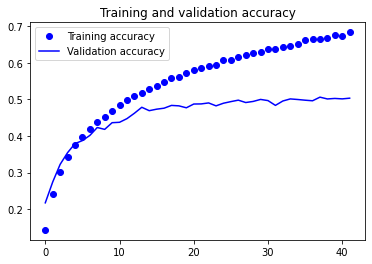

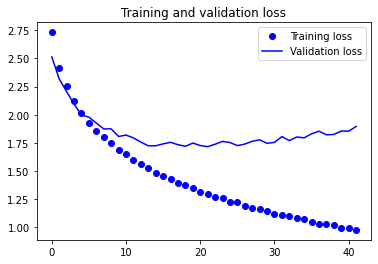

In [13]:
plot_loss(conv_train)

##Implement model over original images with dropout with own regularization

In [14]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=modded_y,l2=0,dropout_plevel=0.4,
                                     loss_function=own_loss(Lambda=0.01),metric_function=accuracy,
                                     train_verbosity=1,stopping_patience=20)

Epoch 1/50
200/200 [==============================] - 21s 97ms/step - loss: 2.7105 - accuracy: 0.1455 - val_loss: 2.4958 - val_accuracy: 0.2291
Epoch 2/50
200/200 [==============================] - 19s 95ms/step - loss: 2.3245 - accuracy: 0.2776 - val_loss: 2.2346 - val_accuracy: 0.3081
Epoch 3/50
200/200 [==============================] - 18s 90ms/step - loss: 2.0903 - accuracy: 0.3510 - val_loss: 2.0339 - val_accuracy: 0.3753
Epoch 4/50
200/200 [==============================] - 19s 95ms/step - loss: 1.9203 - accuracy: 0.4021 - val_loss: 1.8725 - val_accuracy: 0.4235
Epoch 5/50
200/200 [==============================] - 18s 90ms/step - loss: 1.7881 - accuracy: 0.4422 - val_loss: 1.8490 - val_accuracy: 0.4273
Epoch 6/50
200/200 [==============================] - 18s 91ms/step - loss: 1.6766 - accuracy: 0.4751 - val_loss: 1.7492 - val_accuracy: 0.4637
Epoch 7/50
200/200 [==============================] - 18s 90ms/step - loss: 1.5887 - accuracy: 0.5002 - val_loss: 1.7108 - val_accuracy:

In [15]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0.4)

Accuracy over the test with normal dropout (P value:  0.4 ) set is:  0.5444
Accuracy over test set with MC dropout (P value:  0.4 ) set is: 0.6111
Average standard deviation of classification: 0.20475967
Average standard deviation of misclassified samples: 0.24295561


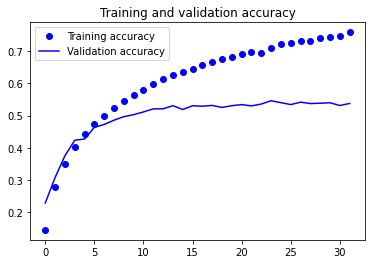

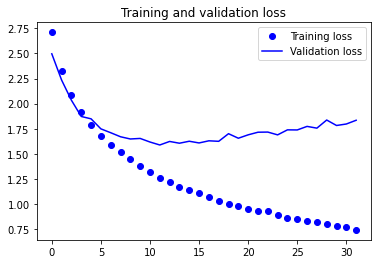

In [16]:
plot_loss(conv_train)

##Implement model over original images with dropout with L2 regularization

In [17]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=200,num_classes=20,train_data=x_train/255,
                                     train_label=y_onehot_train,l2=0.0005,dropout_plevel=0.4,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=20)

Epoch 1/200
200/200 [==============================] - 19s 92ms/step - loss: 3.1720 - accuracy: 0.1167 - val_loss: 2.8144 - val_accuracy: 0.1638
Epoch 2/200
200/200 [==============================] - 19s 95ms/step - loss: 2.6559 - accuracy: 0.2006 - val_loss: 2.5151 - val_accuracy: 0.2414
Epoch 3/200
200/200 [==============================] - 19s 95ms/step - loss: 2.4600 - accuracy: 0.2648 - val_loss: 2.3602 - val_accuracy: 0.2898
Epoch 4/200
200/200 [==============================] - 19s 95ms/step - loss: 2.3175 - accuracy: 0.3155 - val_loss: 2.2817 - val_accuracy: 0.3288
Epoch 5/200
200/200 [==============================] - 19s 95ms/step - loss: 2.2365 - accuracy: 0.3452 - val_loss: 2.2156 - val_accuracy: 0.3500
Epoch 6/200
200/200 [==============================] - 19s 95ms/step - loss: 2.1634 - accuracy: 0.3713 - val_loss: 2.1602 - val_accuracy: 0.3716
Epoch 7/200
200/200 [==============================] - 18s 90ms/step - loss: 2.1089 - accuracy: 0.3917 - val_loss: 2.1533 - val_ac

In [18]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0.4)

Accuracy over the test with normal dropout (P value:  0.4 ) set is:  0.5674
Accuracy over test set with MC dropout (P value:  0.4 ) set is: 0.6248
Average standard deviation of classification: 0.15862772
Average standard deviation of misclassified samples: 0.17404252


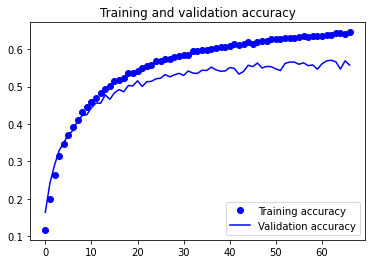

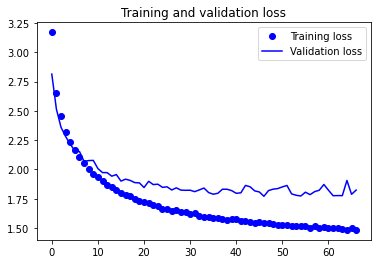

In [19]:
plot_loss(conv_train)